In [1]:
include("../LightconeMLP.jl")

train_markov (generic function with 1 method)

In [2]:
past_depth = 8
c = 1

1

In [2]:
model = lcMLP(past_depth, c)

Chain(
  Dense(80, 80, σ),                     # 6_480 parameters
  Dense(80, 40, σ),                     # 3_240 parameters
  Dense(40, 1, σ),                      # 41 parameters
)                   # Total: 6 arrays, 9_761 parameters, 38.504 KiB.

In [14]:
opt = Flux.Optimise.Optimiser(Flux.Optimise.WeightDecay(1e-6), Flux.ADAM(1e-4))

Flux.Optimise.Optimiser(Any[Flux.Optimise.WeightDecay(1.0e-6), Flux.Optimise.ADAM(0.0001, (0.9, 0.999), IdDict{Any, Any}())])

In [11]:
scores = [];

In [12]:
training = circle_map_local_data(40, 200, 600, past_depth, c; 
                               transient=100, coupling=1.0, nonlinearity=1.0);

In [13]:
size(training[1])

(80, 4736000)

In [14]:
size(training[2])

(1, 4736000)

In [15]:
data = Flux.Data.DataLoader(training, batchsize=4_000,shuffle=true);

In [16]:
train_local(model, data, 40, opt, scores)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/adamrupe/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training epoch 40: 100%|████████████████████████████████| Time: 0:00:58
  loss:  0.0011583479087921447


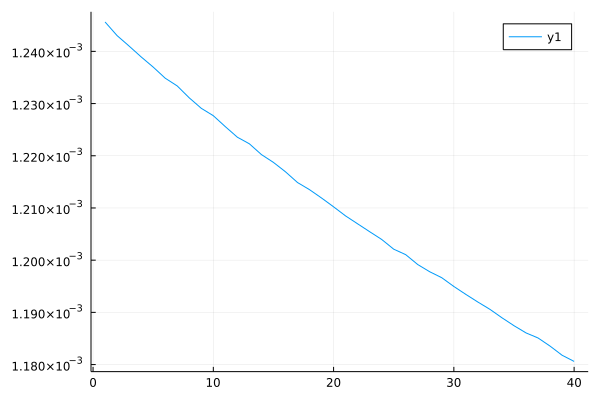

In [17]:
Plots.plot(scores[1:end])

In [3]:
BSON.@load "cml_local_model.bson" model

In [19]:
initial = rand(100)
transient = 100
time = 200
coupling = 1.0
nonlinearity = 1.0
field = map_lattice(initial, transient+time, circle_map; coupling=coupling, nonlinearity=nonlinearity);

In [20]:
tfield = permutedims(field[transient+2:end, :], (2,1))
size(tfield)

(100, 200)

In [21]:
size(tfield[:, 101:end])

(100, 100)

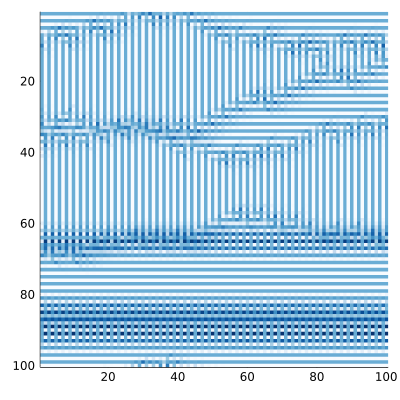

In [22]:
diagram(tfield[:, 101:end]; color=:Blues, scale=400)

In [23]:
full = local_mlp_forecast(tfield[:, 1:100], 100, model, 8, 1)
size(full)

(100, 100)

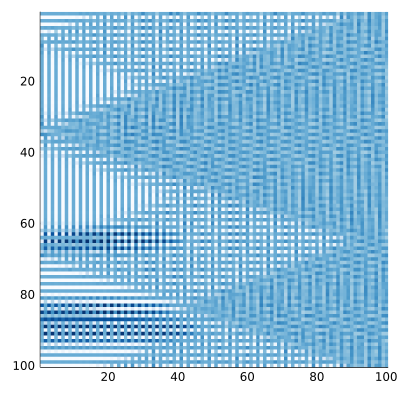

In [24]:
diagram(full; color=:Blues, scale=400)

In [30]:
BSON.@save "cml_local_model.bson" model

In [4]:
training = circle_map_markov_data(120, 100, 600, past_depth, c; 
                               transient=100, coupling=1.0, nonlinearity=1.0);

In [5]:
size(training[2])

(100, 1, 71040)

In [6]:
size(training[2])

(100, 1, 71040)

In [7]:
opt = Flux.Optimise.Optimiser(Flux.Optimise.WeightDecay(1e-6), Flux.ADAM(1e-4))

Flux.Optimise.Optimiser(Any[Flux.Optimise.WeightDecay(1.0e-6), Flux.Optimise.ADAM(0.0001, (0.9, 0.999), IdDict{Any, Any}())])

In [8]:
scores = [];

In [9]:
data = Flux.Data.DataLoader(training, batchsize=200,shuffle=true);

In [10]:
train_markov(model, data, 40, opt, scores, past_depth, c)

LoadError: Mutating arrays is not supported -- called setindex!(::Matrix{Float64}, _...)

In [21]:
markov_loss(model, data.data[1][:,:,1], data.data[2][:, 1], past_depth, c)

0.0042207022484828825

In [24]:
full = local_mlp_forecast(tfield[:, 1:100], 1, model, 8, 1)
size(full)

(100, 1)

In [26]:
size(training[2])

(100, 71040)

In [27]:
size(reshape(training[2], (100,1,71040)))

(100, 1, 71040)

In [7]:
function stfield_local_data(field, past_depth, c)
    plcs = permutedims(extract_plcs(field, past_depth, c), (2,1))
    inputs = plcs[2:end, :]
    outputs = plcs[1:1, :]
    return (inputs, outputs)
end

stfield_local_data (generic function with 1 method)

In [6]:
size(tfield)

(100, 200)

In [8]:
ins, outs = stfield_local_data(tfield, 3, 1);

In [9]:
size(ins)

(15, 19700)

In [10]:
size(outs)

(1, 19700)

In [11]:
lightcone_size(3,1)

16

In [19]:
import NPZ

In [21]:
ks_train = NPZ.npzread("../KS_train.npy");

In [22]:
size(ks_train)

(64, 10000)

In [17]:
? Flux.mse

```
mse(ŷ, y; agg = mean)
```

Return the loss corresponding to mean square error:

```
agg((ŷ .- y) .^ 2)
```

See also: [`mae`](@ref), [`msle`](@ref), [`crossentropy`](@ref).

# Example

```jldoctest
julia> y_model = [1.1, 1.9, 3.1];

julia> y_true = 1:3;

julia> Flux.mse(y_model, y_true)
0.010000000000000018
```


In [20]:
lightcone_size(8,1)

81

In [32]:
size(model(zeros(80, 3)))

(1, 3)

In [37]:
Flux.mse(model(zeros(80,3)), zeros(1,3))

0.0015077705802532609

In [ ]:
function markov_loss_single(model, input, output, past_depth, c)
    pred = local_mlp_forecast(input, 1, model, past_depth, c)
    loss = Flux.mse(pred, output)
    return loss
end

In [35]:
function markov_loss_batch(model, inputs, outputs, past_depth, c)
    n_batch = size(input)[end]
    losses = Array{Float64}(undef, n_batch)
    for i = 1:n_batch
        input = inputs[:,:, i]
        output = outputs[:,:, i]
        loss = markov_loss_single(model, input, outpt, past_depth, c)
        losses[i] = loss
    end
    return Flux.mean(losses)
end

markov_loss_batch (generic function with 1 method)

In [39]:
Flux.mse([1,1], [2,3])

2.5